In [3]:
import pandas as pd
from datetime import datetime
import dateparser
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer



### TO DO:
- Analyse of NaN with distribution plots
- Correlation Matrix to see which features are important
- Chi_2 score

Retours :

- Covariate shift : AUC, s’il arrive a distinguer qu’une feature appartient plus à du train que du test (70%) on supprime la feature.
- Poids de similarité : si une observation du train est proche d’une observation du test —> pondérer
- Ensemble learning : predict_proba, mettre un seuil sur la probabilité !!
- Faire du sample_weights 

# Exploratory Data Analysis

In [10]:
# Read csvs
train_df = pd.read_csv('train.csv', index_col=0)
train_x = train_df[['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',]]
train_y = train_df[['label']]
test_x = pd.read_csv('test.csv', index_col=0)

In [11]:
print('Size of the training set ', train_df.shape)
print('Size of the testing set ', test_x.shape)

Size of the training set  (24840, 13)
Size of the testing set  (10647, 12)


In [12]:
l_bin_var = ['salutations', 'designation', 'bcced']
l_cont_var = ['ccs', 'images', 'urls', 'chars_in_subject', 'chars_in_body']
l_cat_var = ['org', 'tld', 'mail_type']

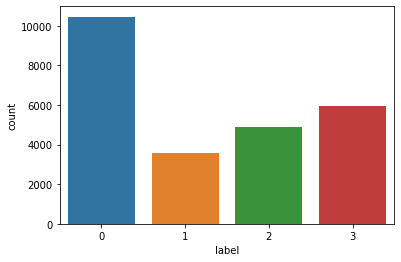

In [13]:
sns.countplot(train_df['label'])
plt.show()

In [14]:
train_df.groupby('label').count() / len(train_df) *100

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body
label,,,,,,,,,,,,
0,42.113527,37.403382,37.403382,42.113527,42.113527,41.827697,42.113527,42.113527,42.113527,42.113527,42.113527,42.113527
1,14.408213,14.408213,14.408213,14.408213,14.408213,14.408213,14.408213,14.408213,14.408213,14.408213,14.408213,14.408213
2,19.621578,19.259259,19.259259,19.621578,19.621578,19.621578,19.621578,19.621578,19.621578,19.621578,19.621578,19.621578
3,23.856683,23.788245,23.788245,23.856683,23.856683,23.856683,23.856683,23.856683,23.856683,23.856683,23.856683,23.856683


In [15]:
[{0: 42, 1: 14}, {0: 42, 1: 5}, {0: 42, 1: 1}, {0: 42, 1: 1}] 

[{0: 42, 1: 14}, {0: 42, 1: 5}, {0: 42, 1: 1}, {0: 42, 1: 1}]

### NaN Analysis

In [16]:
train_df.isna().sum() / 24840 * 100

date                0.000000
org                 5.140902
tld                 5.140902
ccs                 0.000000
bcced               0.000000
mail_type           0.285829
images              0.000000
urls                0.000000
salutations         0.000000
designation         0.000000
chars_in_subject    0.000000
chars_in_body       0.000000
label               0.000000
dtype: float64

In [17]:
test_x.isna().sum() / 10647 * 100

date                0.000000
org                 5.475721
tld                 5.475721
ccs                 0.000000
bcced               0.000000
mail_type           0.272377
images              0.000000
urls                0.000000
salutations         0.000000
designation         0.000000
chars_in_subject    0.000000
chars_in_body       0.000000
dtype: float64

We only have Nan in categorical values, and it seems that when there is a Nan in orgit entails a Nan in tld <br>
For __org__ and __tld__ it represents more than 5%, so we need to handle with that. It's less important for __mail_type__. At the beggining, we can fill missing values by the string "missing"

In [18]:
#Mandatory feature engineering
train_df["org"] = train_df["org"].fillna('org_missing')
train_df["tld"] = train_df["tld"].fillna('tld_missing')
train_df["mail_type"] = train_df["mail_type"].fillna('mail_type/missing')
test_x["org"] = test_x["org"].fillna('org_missing')
test_x["tld"] = test_x["tld"].fillna('tld_missing')
test_x["mail_type"] = test_x["mail_type"].fillna('mail_type/missing')

In [19]:
def fe_mandatory(train_df, test_x):
    train_df["org"] = train_df["org"].fillna('org_missing')
    train_df["tld"] = train_df["tld"].fillna('tld_missing')
    train_df["mail_type"] = train_df["mail_type"].fillna('mt_missing/mt_missing')
    test_x["org"] = test_x["org"].fillna('org_missing')
    test_x["tld"] = test_x["tld"].fillna('tld_missing')
    test_x["mail_type"] = test_x["mail_type"].fillna('mt_missing/mt_missing')
    return train_df, test_x

In [20]:
#Preprocessing lower case every categorical features
def fe_lower_case_strip(train_df, test_x):
    
    l_cat_var = ['org', 'tld', 'mail_type']
    for i in range(len(l_cat_var)):
        train_df[l_cat_var[i]] = train_df[l_cat_var[i]].str.lower()
        test_x[l_cat_var[i]] = test_x[l_cat_var[i]].str.lower()
        train_df[l_cat_var[i]] = train_df[l_cat_var[i]].str.strip()
        test_x[l_cat_var[i]] = test_x[l_cat_var[i]].str.strip()
    return train_df, test_x

In [21]:
## Handle lower case
train_df, test_x = fe_lower_case_strip(train_df, test_x)

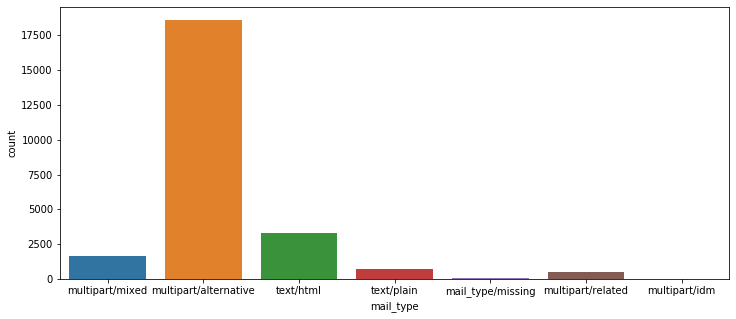

In [22]:
plt.figure(figsize=(12, 5))
sns.countplot(train_df.mail_type)
plt.show()

### Date Feature

In [23]:
#Obtain clean date

#1. There are no missing values in the date column, but several formats exist:
#(a) Sun, 28 Aug 2016 00:17:44 +0000
#(b) 11-MAR-2018 20:40:58
#(c) Mon, 8 Apr 2013 09:59:21
#(d) 25 Apr 2019 07:13:43 -0400
#...
#2. There are also incorrect time zones values, '+0580', which I changed to '0530'

def change_date_format(X):
    X['date'] = X['date'].str.replace(r' \(.*\)', '')
    X['date'] = X['date'].str.rstrip()
    X['date'] = X['date'].str.replace('-0000', '+0000')
    X['date'] = X['date'].str.replace('0580', '0530')
    X['datetime'] = X['date'].apply(dateparser.parse, languages=['en'])
    return X

def date_feature_engineering(df):
    df['year'] = df['datetime'].apply(lambda x:x.year)
    df['month'] = df['datetime'].apply(lambda x:x.month)
    df['day'] = df['datetime'].apply(lambda x:x.day)
    df['hour'] = df['datetime'].apply(lambda x:x.hour)
    df['minute'] = df['datetime'].apply(lambda x:x.minute)
    df['second'] = df['datetime'].apply(lambda x:x.second)
    df['weekday'] = df['datetime'].apply(lambda x:x.weekday())
    df['timezone'] = df['datetime'].apply(lambda x:x.tzname())
    return df

In [24]:
#Preproccesinf for date formating
def fe_date_preprocess(train_df, test_x):
    train_df = change_date_format(train_df)
    test_x  = change_date_format(test_x)
    train_df = date_feature_engineering(train_df)
    test_x  = date_feature_engineering(test_x)
    
    train_df.drop(['date'], axis=1, inplace=True)
    train_df.drop(['datetime'], axis=1, inplace=True)

    test_x.drop(['date'], axis=1, inplace=True)
    test_x.drop(['datetime'], axis=1, inplace=True)
    
    return train_df, test_x

## Binary features
- salutations
- designation
- bcced

In [25]:
l_bin_var = ['salutations', 'designation', 'bcced']

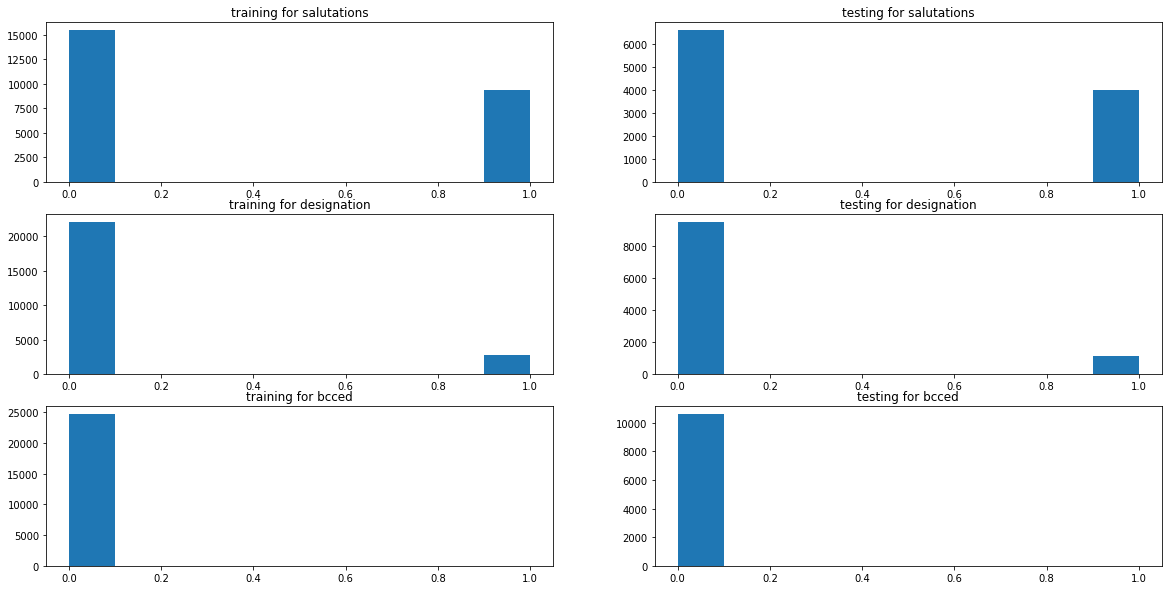

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
for i in range(len(l_bin_var)):
    axes[i, 0].hist(train_x[l_bin_var[i]])
    title = 'training for ' + l_bin_var[i]
    axes[i, 0].set_title(title)

    axes[i, 1].hist(test_x[l_bin_var[i]])
    title = 'testing for ' + l_bin_var[i]
    axes[i, 1].set_title(title)
    
plt.show()

### <font color='red'> Commentaries : </font>
- We see that bcced feature always is equal to 0 in training and testing dataset
- Let's check the other binary features

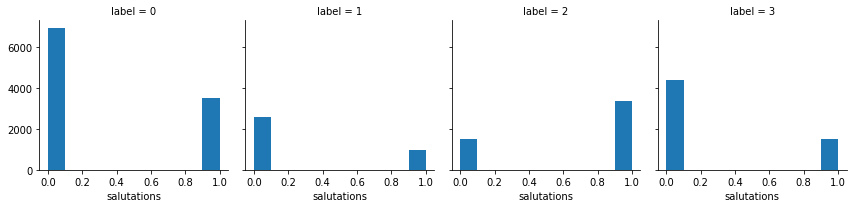

In [27]:
g = sns.FacetGrid(train_df, col="label")
g = g.map(plt.hist, "salutations", bins=10)

In [28]:
crosstab_salutations = pd.crosstab(train_df['label'], train_df['salutations'])
crosstab_salutations

salutations,0,1
label,,
0,6959,3502
1,2604,975
2,1512,3362
3,4410,1516


In [29]:
stats_salutations = stats.chi2_contingency(crosstab_salutations)
print('Chi Square value is ', stats_salutations[0])
print('p-value value is ', stats_salutations[1])
print('Degree of freedom value is ', stats_salutations[2])

Chi Square value is  2647.8630985862555
p-value value is  0.0
Degree of freedom value is  3


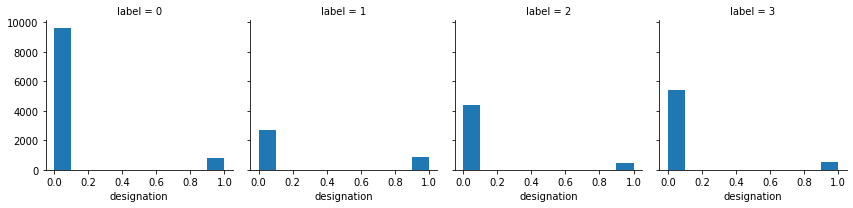

In [30]:
g = sns.FacetGrid(train_df, col="label")
g = g.map(plt.hist, "designation", bins=10)

In [31]:
crosstab_designation = pd.crosstab(train_df['label'], train_df['designation'])
crosstab_designation

designation,0,1
label,,
0,9640,821
1,2711,868
2,4406,468
3,5388,538


In [32]:
stats_designation = stats.chi2_contingency(crosstab_designation)
print('Chi Square value is ', stats_designation[0])
print('p-value value is ', stats_designation[1])
print('Degree of freedom value is ', stats_designation[2])

Chi Square value is  789.2005567404859
p-value value is  9.513921284832808e-171
Degree of freedom value is  3


### <font color='red'> Commentaries : </font>
Both salutations and designation are correlated with the label

## Continious features
- ccs
- images
- urls
- chars_in_subject
- chars_in_body

Check distribution of these variables

In [33]:
l_cont_var = ['ccs', 'images', 'urls', 'chars_in_subject', 'chars_in_body']

Distribution of continious variables for the <b> training </b> set and <b> testing </b> set

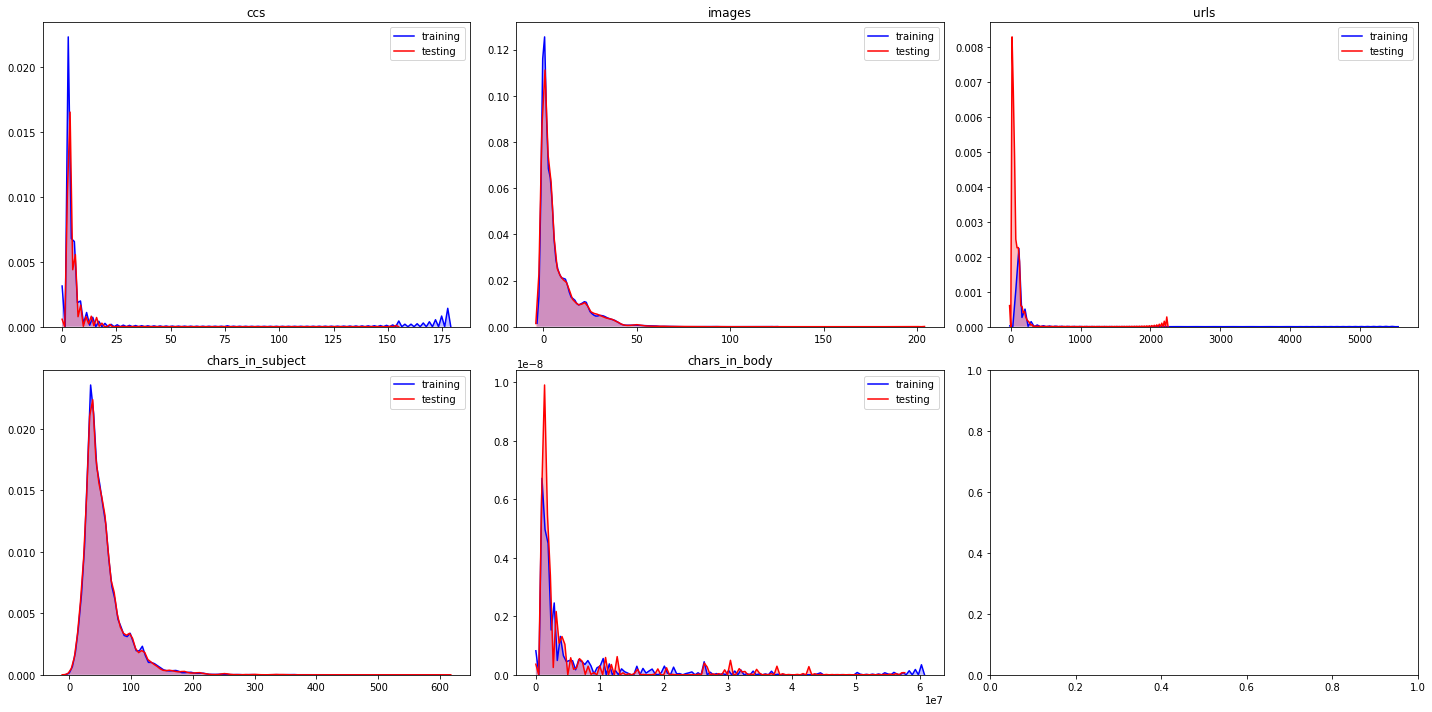

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()
for i in range(len(l_cont_var)):
    axes[i].set_title(l_cont_var[i])
    sns.kdeplot(train_df[l_cont_var[i]], shade=True, ax=axes[i], color="b", label='training', legend=True)
    sns.kdeplot(test_x[l_cont_var[i]], shade=True, ax=axes[i], color="r", label='testing', legend=True)
plt.tight_layout()    

C:\Users\Camille\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Camille\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


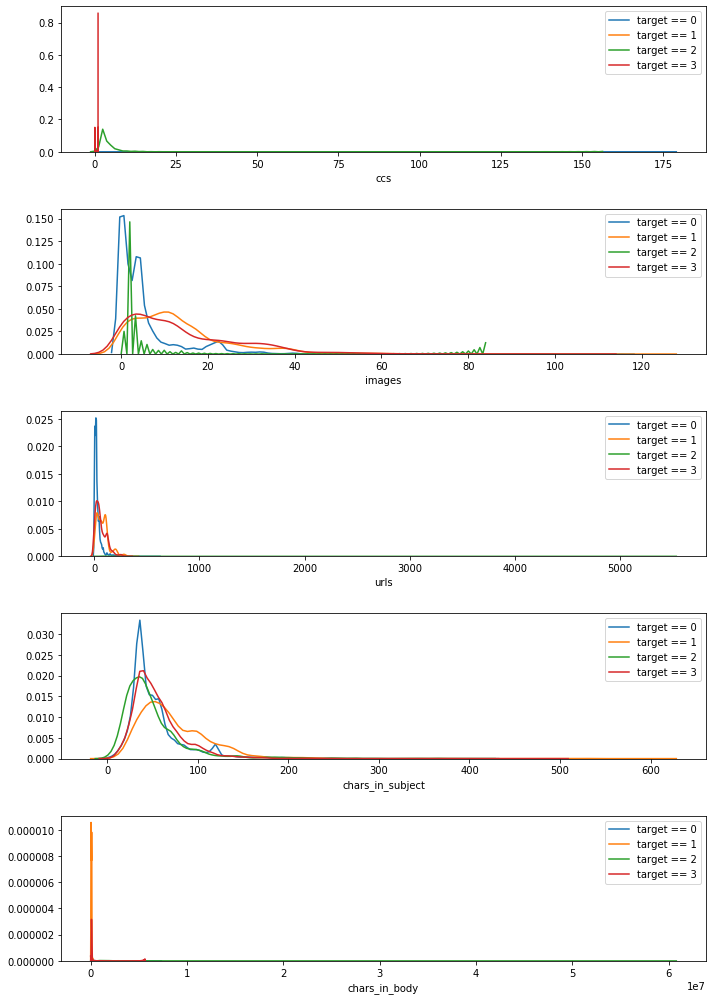

In [35]:
plt.figure(figsize = (10, 14))
# iterate through the new features
for i, feature in enumerate(l_cont_var):
    
    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train_df.loc[train_df['label'] == 0, feature], label = 'target == 0')
    sns.kdeplot(train_df.loc[train_df['label'] == 1, feature], label = 'target == 1')
    sns.kdeplot(train_df.loc[train_df['label'] == 2, feature], label = 'target == 2')
    sns.kdeplot(train_df.loc[train_df['label'] == 3, feature], label = 'target == 3')
    
    # Label the plots
    plt.xlabel('%s' % feature) 
    
plt.tight_layout(h_pad = 2.5)

If we normalized our data

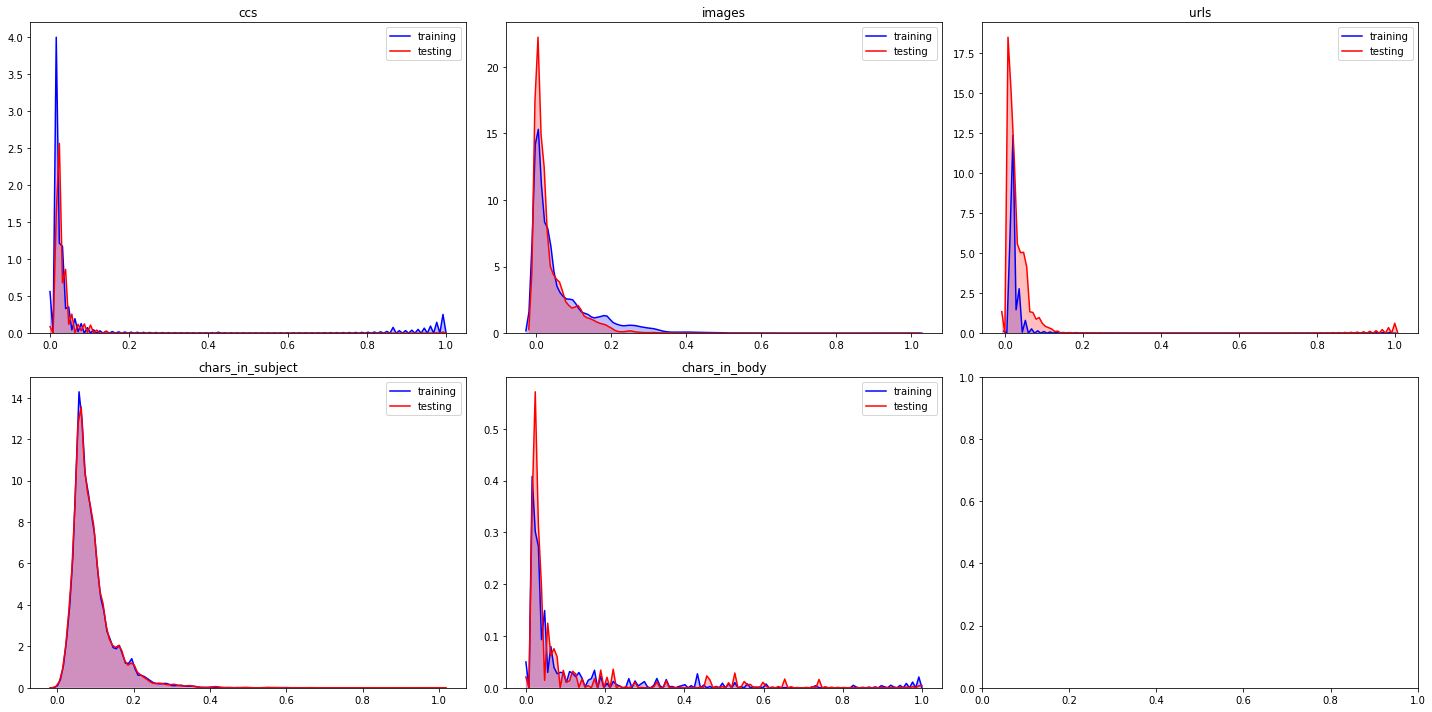

In [36]:
min_max_scaler_train = MinMaxScaler()
train_df_norm = min_max_scaler_train.fit_transform(train_df[l_cont_var])
train_df_norm = pd.DataFrame(train_df_norm, columns=l_cont_var)

min_max_scaler_test = MinMaxScaler()
test_x_norm = min_max_scaler_test.fit_transform(test_x[l_cont_var])
test_x_norm = pd.DataFrame(test_x_norm, columns=l_cont_var)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()
for i in range(len(l_cont_var)):
    axes[i].set_title(l_cont_var[i])
    sns.kdeplot(train_df_norm[l_cont_var[i]], shade=True, ax=axes[i], color="b", label='training', legend=True)
    sns.kdeplot(test_x_norm[l_cont_var[i]], shade=True, ax=axes[i], color="r", label='testing', legend=True)
plt.tight_layout() 

### <font color='red'> Commentaries : </font>
- css: distributions are not exactly similar, especialy for the tail
- images: distribution are quite similar
- urls: distribution are differents, needs to be analyse
- chars_in_subjects: distribution are the same!
- chars_in_body: a lot of peaks but similar <br>
<br>

__Globaly, distribution are the same, we can comute our model without more feature engineering on these features__

### Categorical features

In [37]:
l_cat_var = ['org', 'tld', 'mail_type']

In [38]:
for i in range(len(l_cat_var)):
    print('TRAINING : Distinct categories for ', l_cat_var[i], ' are ', train_df[l_cat_var[i]].nunique())

TRAINING : Distinct categories for  org  are  649
TRAINING : Distinct categories for  tld  are  188
TRAINING : Distinct categories for  mail_type  are  7


In [39]:
l_cat_var = ['org', 'tld', 'mail_type']
for i in range(len(l_cat_var)):
    print('TESTING : Distinct categories for ', l_cat_var[i], ' are ', test_x[l_cat_var[i]].nunique())

TESTING : Distinct categories for  org  are  474
TESTING : Distinct categories for  tld  are  141
TESTING : Distinct categories for  mail_type  are  6


In [40]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

def sym_diff(lst1, lst2):
    return set(lst1).symmetric_difference(set(lst2))

In [41]:
l_cat_var = ['org', 'tld', 'mail_type']
for i in range(len(l_cat_var)):
    intersect_list = intersection(test_x[l_cat_var[i]].unique(), train_df[l_cat_var[i]].unique())
    diff_list = sym_diff(test_x[l_cat_var[i]].unique(), train_df[l_cat_var[i]].unique())
    print('Size of intersection for ', l_cat_var[i], ' is ', len(intersect_list))
    print('Size of symm_diff for ', l_cat_var[i], ' is ', len(diff_list), ' \n')

Size of intersection for  org  is  409
Size of symm_diff for  org  is  305  

Size of intersection for  tld  is  123
Size of symm_diff for  tld  is  83  

Size of intersection for  mail_type  is  6
Size of symm_diff for  mail_type  is  1  



To be included in the org_encoding function and tld_encoding function

In [42]:
def diff_cat_values(train_df, test_x):
    diff_list = sym_diff(test_x['org'].unique(), train_df['org'].unique())
    train_df['org_others'] = np.where(train_df['org'].isin(diff_list), 1, 0)
    test_x['org_others'] = np.where(test_x['org'].isin(diff_list), 1, 0)

    diff_list = sym_diff(test_x['tld'].unique(), train_df['tld'].unique())
    train_df['tld_others'] = np.where(train_df['tld'].isin(diff_list), 1, 0)
    test_x['tld_others'] = np.where(test_x['tld'].isin(diff_list), 1, 0)
    
    return train_df, test_x

Not relevant: Set only common values for these features

In [43]:
#l_cat_var = ['org', 'tld', 'mail_type']
#for i in range(len(l_cat_var)):
#    intersect_list = intersection(test_x[l_cat_var[i]].unique(), train_x[l_cat_var[i]].unique())
#    print('Initial size of train for ', l_cat_var[i], ' is ', train_x.shape[0])
#    print('Initial size of test for ', l_cat_var[i], ' is ', test_x.shape[0])
#    final_train_size = train_df[train_df[l_cat_var[i]].isin(intersect_list)].shape[0]
#    loss_train = round((final_train_size - train_df.shape[0])*100 / train_df.shape[0], 2)
#    print('Size of intersection for train', train_df[train_df[l_cat_var[i]].isin(intersect_list)].shape[0])
#    print('Train Loss of ', loss_train, '%')
#    final_test_size = test_x[test_x[l_cat_var[i]].isin(intersect_list)].shape[0]
#    loss_test = round((final_test_size - test_x.shape[0])*100 / test_x.shape[0], 2)
#    print('Size of intersection for test', test_x[test_x[l_cat_var[i]].isin(intersect_list)].shape[0])
#    print('Test Loss of ', loss_test, '%', ' \n')

In [45]:
#Preprocessing to filter common values for multi-class features
#def common_values(train_df, test_x):
#    l_cat_var = ['org', 'tld', 'mail_type']
#    for i in range(len(l_cat_var)):
#        intersect_list = intersection(test_x[l_cat_var[i]].unique(), train_df[l_cat_var[i]].unique())
#        train_df = train_df[train_df[l_cat_var[i]].isin(intersect_list)]
#        test_x = test_x[test_x[l_cat_var[i]].isin(intersect_list)]
#    return train_df, test_x

In [46]:
#train_df, test_x = common_values(train_df, test_x)

__Crosstab of mail_type__

In [47]:
pd.crosstab(train_df['mail_type'], train_df['label'])

label,0,1,2,3
mail_type,,,,
mail_type/missing,71,0,0,0
multipart/alternative,7231,3407,3657,4301
multipart/idm,1,0,0,0
multipart/mixed,444,123,618,453
multipart/related,129,0,360,20
text/html,1983,45,101,1152
text/plain,602,4,138,0


__Crosstab of org__

In [48]:
crosstab_org = pd.crosstab(train_df['org'], train_df['label'], margins=True, margins_name="Total")
crosstab_org.sort_values(['Total'], ascending=False).tail(10)

label,0,1,2,3,Total
org,,,,,
mysql,1,0,0,0,1
mx2,1,0,0,0,1
mailer1,1,0,0,0,1
murraystate,0,0,0,1,1
mpi-sb,1,0,0,0,1
bbnl,1,0,0,0,1
moneygram,1,0,0,0,1
minglebox,1,0,0,0,1
mega,1,0,0,0,1


__Crosstab of tdl__

In [49]:
crosstab_tld = pd.crosstab(train_df['tld'], train_df['label'], margins=True, margins_name="Total")
crosstab_tld.sort_values(['Total'], ascending=False).tail(10)

label,0,1,2,3,Total
tld,,,,,
play4free.com,1,0,0,0,1
esa.int,1,0,0,0,1
email.amazon.com,1,0,0,0,1
ecp.fr,0,0,1,0,1
sap.stampmail.in,1,0,0,0,1
scientific-direct.net,0,0,0,1,1
drdo.in,1,0,0,0,1
me,1,0,0,0,1
de,0,0,0,1,1


Let's check the vlaues for these features that are only for a unique label

In [50]:
train_df.org.nunique()

649

In [51]:
train_df[['org', 'tld']].head(10)

,org,tld
0,amazon,in
1,linkedin,com
2,quora,com
3,iiitd,ac.in
4,mail,paypal.com
5,twitter,com
6,iiitd,ac.in
7,nvidia,com
8,ieee,org
9,crazydomains,in


__org__

In [52]:
#Label 0
l_label_0 = crosstab_org[(crosstab_org.loc[:,1] == 0) & (crosstab_org.loc[:,2] == 0) & (crosstab_org.loc[:,3] == 0)].index
print('Label 0 :', len(l_label_0))
#Label 1
l_label_1 = crosstab_org[(crosstab_org.loc[:,0] == 0) & (crosstab_org.loc[:,2] == 0) & (crosstab_org.loc[:,3] == 0)].index
print('Label 1 :', len(l_label_1))
#Label 2
l_label_2 = crosstab_org[(crosstab_org.loc[:,1] == 0) & (crosstab_org.loc[:,0] == 0) & (crosstab_org.loc[:,3] == 0)].index
print('Label 2 :', len(l_label_2))
#Label 3
l_label_3 = crosstab_org[(crosstab_org.loc[:,1] == 0) & (crosstab_org.loc[:,2] == 0) & (crosstab_org.loc[:,0] == 0)].index
print('Label 3 :', len(l_label_3))

Label 0 : 381
Label 1 : 8
Label 2 : 13
Label 3 : 80


_Le probleme c'est que si un nom de domaine est peu discriminant alors il sera dans la meme feature que les noms de domaines très discriminant (même impact). Cela peut donner une mauvaise indication à l'algo_ <br>
A voir si on peut améliorer cela

In [53]:
def fe_org_encoding(train_df, test_x, threshold=5):
    
    ###Doing categories for values that only appear for a unique label at least 5 times
    crosstab_org = pd.crosstab(train_df['org'], train_df['label'].astype(int), margins=True, margins_name="Total")
    
    l_label_0 = crosstab_org[(crosstab_org.loc[:,1] == 0) & (crosstab_org.loc[:,2] == 0) & 
                             (crosstab_org.loc[:,3] == 0) & (crosstab_org.loc[:,0] <= threshold)].index
    train_df['org_label_0'] = np.where(train_df['org'].isin(l_label_0), 1, 0)
    test_x['org_label_0'] = np.where(test_x['org'].isin(l_label_0), 1, 0)

    l_label_1 = crosstab_org[(crosstab_org.loc[:,0] == 0) & (crosstab_org.loc[:,2] == 0) & 
                             (crosstab_org.loc[:,3] == 0) & (crosstab_org.loc[:,1] <= threshold)].index
    train_df['org_label_1'] = np.where(train_df['org'].isin(l_label_0), 1, 0)
    test_x['org_label_1'] = np.where(test_x['org'].isin(l_label_0), 1, 0)
    
    l_label_2 = crosstab_org[(crosstab_org.loc[:,1] == 0) & (crosstab_org.loc[:,0] == 0) & 
                             (crosstab_org.loc[:,3] == 0) & (crosstab_org.loc[:,2] <= threshold)].index
    train_df['org_label_2'] = np.where(train_df['org'].isin(l_label_0), 1, 0)
    test_x['org_label_2'] = np.where(test_x['org'].isin(l_label_0), 1, 0)
    
    l_label_3 = crosstab_org[(crosstab_org.loc[:,1] == 0) & (crosstab_org.loc[:,2] == 0) & 
                             (crosstab_org.loc[:,0] == 0) & (crosstab_org.loc[:,3] <= threshold)].index
    train_df['org_label_3'] = np.where(train_df['org'].isin(l_label_0), 1, 0)
    test_x['org_label_3'] = np.where(test_x['org'].isin(l_label_0), 1, 0)
    
    ###Doing an other_feature do gather values that only appear in test or in train
    diff_list = sym_diff(test_x['org'].unique(), train_df['org'].unique())
    train_df['org_others'] = np.where(train_df['org'].isin(diff_list), 1, 0)
    test_x['org_others'] = np.where(test_x['org'].isin(diff_list), 1, 0)
    
    ###Dummification of the other values    
    l_org_dummification = set(train_df.org.unique()) - set(l_label_0) - set(l_label_1) - set(l_label_2) - set(l_label_3) - set(diff_list)    
    l_org_dummification = ['org_' + s for s in l_org_dummification]
    train_df_dummies_org = pd.get_dummies(train_df['org'], prefix='org')
    train_df_dummies_org = train_df_dummies_org[l_org_dummification]
    train_df = pd.concat([train_df, train_df_dummies_org],axis=1)
    train_df.drop(['org'],axis=1, inplace=True)
    
    test_x_dummies_org = pd.get_dummies(test_x['org'], prefix='org')
    test_x_dummies_org = test_x_dummies_org[l_org_dummification]
    test_x = pd.concat([test_x, test_x_dummies_org],axis=1)
    test_x.drop(['org'],axis=1, inplace=True)
    
    return train_df, test_x

__tld__

In [54]:
#Label 0
l_label_0 = crosstab_tld[(crosstab_tld.loc[:,1] == 0) & (crosstab_tld.loc[:,2] == 0) & (crosstab_tld.loc[:,3] == 0)].index
print('Label 0 :', len(l_label_0))
#Label 1
l_label_1 = crosstab_tld[(crosstab_tld.loc[:,0] == 0) & (crosstab_tld.loc[:,2] == 0) & (crosstab_tld.loc[:,3] == 0)].index
print('Label 1 :', len(l_label_1))
#Label 2
l_label_2 = crosstab_tld[(crosstab_tld.loc[:,1] == 0) & (crosstab_tld.loc[:,0] == 0) & (crosstab_tld.loc[:,3] == 0)].index
print('Label 2 :', len(l_label_2))
#Label 3
l_label_3 = crosstab_tld[(crosstab_tld.loc[:,1] == 0) & (crosstab_tld.loc[:,2] == 0) & (crosstab_tld.loc[:,0] == 0)].index
print('Label 3 :', len(l_label_3))

Label 0 : 86
Label 1 : 4
Label 2 : 5
Label 3 : 33


In [55]:
def fe_tld_encoding(train_df, test_x, threshold=5):
    crosstab_tld = pd.crosstab(train_df['tld'], train_df['label'].astype(int), margins=True, margins_name="Total")
    
    l_label_0 = crosstab_tld[(crosstab_tld.loc[:,1] == 0) & (crosstab_tld.loc[:,2] == 0) & 
                             (crosstab_tld.loc[:,3] == 0) & (crosstab_tld.loc[:,0] <= threshold)].index
    train_df['tld_label_0'] = np.where(train_df['tld'].isin(l_label_0), 1, 0)
    test_x['tld_label_0'] = np.where(test_x['tld'].isin(l_label_0), 1, 0)

    l_label_1 = crosstab_tld[(crosstab_tld.loc[:,0] == 0) & (crosstab_tld.loc[:,2] == 0) & 
                             (crosstab_tld.loc[:,3] == 0) & (crosstab_tld.loc[:,1] <= threshold)].index
    train_df['tld_label_1'] = np.where(train_df['tld'].isin(l_label_0), 1, 0)
    test_x['tld_label_1'] = np.where(test_x['tld'].isin(l_label_0), 1, 0)
    
    l_label_2 = crosstab_tld[(crosstab_tld.loc[:,1] == 0) & (crosstab_tld.loc[:,0] == 0) & 
                             (crosstab_tld.loc[:,3] == 0) & (crosstab_tld.loc[:,2] <= threshold)].index
    train_df['tld_label_2'] = np.where(train_df['tld'].isin(l_label_0), 1, 0)
    test_x['tld_label_2'] = np.where(test_x['tld'].isin(l_label_0), 1, 0)
    
    l_label_3 = crosstab_tld[(crosstab_tld.loc[:,1] == 0) & (crosstab_tld.loc[:,2] == 0) & 
                             (crosstab_tld.loc[:,0] == 0) & (crosstab_tld.loc[:,3] <= threshold)].index
    train_df['tld_label_3'] = np.where(train_df['tld'].isin(l_label_0), 1, 0)
    test_x['tld_label_3'] = np.where(test_x['tld'].isin(l_label_0), 1, 0)
    
    ###Doing an other_feature do gather values that only appear in test or in train
    diff_list = sym_diff(test_x['tld'].unique(), train_df['tld'].unique())
    train_df['tld_others'] = np.where(train_df['tld'].isin(diff_list), 1, 0)
    test_x['tld_others'] = np.where(test_x['tld'].isin(diff_list), 1, 0)
    
    ###Dummification of the other values    
    l_tld_dummification = set(train_df.tld.unique()) - set(l_label_0) - set(l_label_1) - set(l_label_2) - set(l_label_3) - set(diff_list)
    l_tld_dummification = ['tld_' + s for s in l_tld_dummification]
    
    train_df_dummies_tld = pd.get_dummies(train_df['tld'], prefix='tld')
    train_df_dummies_tld = train_df_dummies_tld[l_tld_dummification]
    train_df = pd.concat([train_df, train_df_dummies_tld], axis=1)
    train_df.drop(['tld'], axis=1, inplace=True)
    
    test_x_dummies_tld = pd.get_dummies(test_x['tld'], prefix='tld')
    test_x_dummies_tld = test_x_dummies_tld[l_tld_dummification]
    test_x = pd.concat([test_x, test_x_dummies_tld], axis=1)
    test_x.drop(['tld'], axis=1, inplace=True)
    
    return train_df, test_x

In [56]:
def fe_encoding_org_baseline(train_df, test_x):
    
    n = len(train_df)
    
    temp = pd.concat([train_df['org'], test_x['org']], axis=0)
    temp_with_dummies = pd.get_dummies(temp, drop_first=True)
    train_df = pd.concat([train_df, temp_with_dummies[:n]], axis=1)
    test_x = pd.concat([test_x, temp_with_dummies[n:]], axis=1)

    return train_df, test_x

In [57]:
def fe_encoding_tld_baseline(train_df, test_x):
    
    n = len(train_df)
    
    temp = pd.concat([train_df['tld'], test_x['tld']], axis=0)
    temp_with_dummies = pd.get_dummies(temp, drop_first=True)
    train_df = pd.concat([train_df, temp_with_dummies[:n]], axis=1)
    test_x = pd.concat([test_x, temp_with_dummies[n:]], axis=1)

    return train_df, test_x

One-hot Encoding on mail_type

In [58]:
def fe_mail_type(train_df, test_x):
    
    n = len(train_df)
    
    temp = pd.concat([train_df['mail_type'], test_x['mail_type']], axis=0)
    temp_with_dummies = pd.get_dummies(temp, drop_first=True, prefix='mt')
    
    train_df_dummies = temp_with_dummies[:n]
    train_df = pd.concat([train_df, train_df_dummies], axis=1)
    train_df.drop(['mail_type'], axis=1, inplace=True)
    
    test_x_dummies = temp_with_dummies[n:]
    test_x = pd.concat([test_x, test_x_dummies], axis=1)
    test_x.drop(['mail_type'], axis=1, inplace=True)

    return train_df, test_x

In [59]:
def get_tld(x):
    if type(x) != list:
        return np.nan
    if x[-1] == 'in' and len(x) == 2 and x[-2] in ['ac', 'co']:
        return x[-2] + '.' + 'in'
    else:
        return x[-1]
def get_org(x):
    if type(x) != list:
        return np.nan
    if len(x) == 1:
        return np.nan
    if x[-1] == 'in' and x[-2] in ['ac', 'co'] and len(x) == 3:
        return x[-3]   
    if x[-1] == 'in' and x[-2] in ['ac', 'co'] and len(x) == 2:
        return np.nan   
    return x[-2]

In [60]:
def fe_correcting_org_tld(train_df, test_x):
    #Encode labels to numerical values
    n = len(train_df)
    y_train = train_df.label
    temp = pd.concat([train_df, test_x], axis=0, sort=False).drop(['label'], axis=1)

    #Correct the 'org' and 'tld' columns and lowercase them
    split_res = temp['tld'].str.split('.')
    true_tld = split_res.map(get_tld)
    true_org = split_res.map(get_org)
    temp['tld'] = true_tld.fillna(temp['tld']).str.lower()
    temp['org'] = true_org.fillna(temp['org']).str.lower()
    
    train_df = temp[:n]
    train_df = pd.concat([train_df, y_train], axis=1)
    test_x = temp[n:]
    
    return train_df, test_x
    

In [61]:
def fe_split_mail(train_df, test_x):

    train_df['mail_type'] = train_df['mail_type'].str.strip()
    train_df['mail_type_1'] = train_df['mail_type'].str.split('/',expand=True)[0]
    train_df['mail_type_2'] = train_df['mail_type'].str.split('/',expand=True)[1]
    
    test_x['mail_type'] = test_x['mail_type'].str.strip()
    test_x['mail_type_1'] = test_x['mail_type'].str.split('/',expand=True)[0]
    test_x['mail_type_2'] = test_x['mail_type'].str.split('/',expand=True)[1]

    return train_df, test_x

In [50]:
def fe_mail_typeS_encoding(train_df, test_x):
    
    n = len(train_df)
    temp = pd.concat([train_df[['mail_type', 'mail_type_1', 'mail_type_2']], 
                      test_x[['mail_type', 'mail_type_1', 'mail_type_2']]], axis=0)

    temp_with_dummies = pd.get_dummies(temp, drop_first=True, prefix='mt')

    train_df_dummies = temp_with_dummies[:n]
    train_df = pd.concat([train_df, train_df_dummies], axis=1)
    train_df.drop(['mail_type', 'mail_type_1', 'mail_type_2'], axis=1, inplace=True)
    
    test_x_dummies = temp_with_dummies[n:]
    test_x = pd.concat([test_x, test_x_dummies], axis=1)
    test_x.drop(['mail_type', 'mail_type_1', 'mail_type_2'], axis=1, inplace=True)
    
    return train_df, test_x

### <font color='red'> Commentaries : </font>
- Needs to be analysed, perhaps make categories of values that discriminate the target

In [62]:
def fe_frequency(train_df, test_x):
    
    n = len(train_df)
    
    catogorical = ['mail_type','mail_type_1', 'mail_type_2', 'org', 'tld']
    temp = pd.concat([train_df, test_x], axis=0, sort=False)

    for col in catogorical:
        encoding = temp.groupby(col).size()/len(temp)
        temp[col + '_freq'] = temp[col].map(encoding)
        
    train_df = temp[:n]
    test_x = temp[n:]

    return train_df, test_x

In [120]:
def fe_drop_duplicates(train_df, test_x):
    
    n = len(train_df)
    
    temp = pd.concat([train_df, test_x], axis=0)
    #Drop features that have value 1 for only one row
    t1 = temp[:n].sum()
    t2 = temp[n:].sum()
    temp = temp.drop(set(t2[t2==0].index) | set(t1[t1==0].index), axis=1)

    #Drop duplicate columns in the training set
    col_non_dup = (temp[:n].T.drop_duplicates().T).columns
    temp = temp[col_non_dup]
    train_df = temp[:n]
    test_x = temp[n:]
    
    return train_df, test_x

# Feature Engineering

In [63]:
# Read csvs
train_df = pd.read_csv('train.csv', index_col=0)
train_x = train_df[['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',]]
train_y = train_df[['label']]
test_x = pd.read_csv('test.csv', index_col=0)

In [64]:
train_df_0, test_x_0 = fe_mandatory(train_df, test_x)

In [65]:
train_df_0, test_x_0 = fe_lower_case_strip(train_df_0, test_x_0)

In [66]:
train_df_0, test_x_0 = fe_date_preprocess(train_df_0, test_x_0)

In [67]:
train_df_0, test_x_0 = fe_correcting_org_tld(train_df_0, test_x_0)

In [68]:
train_df_0, test_x_0 = fe_split_mail(train_df_0, test_x_0)

In [69]:
train_df_0, test_x_0 = fe_frequency(train_df_0, test_x_0)

In [70]:
train_df_0, test_x_0 = fe_mail_typeS_encoding(train_df_0, test_x_0)

NameError: name 'fe_mail_typeS_encoding' is not defined

In [71]:
train_df_ao, test_x_ao = fe_org_encoding(train_df_0, test_x_0, threshold=30)

In [72]:
train_df_ao, test_x_ao = fe_tld_encoding(train_df_ao, test_x_ao)

In [73]:
train_df_ao, test_x_ao = fe_drop_duplicates(train_df_ao, test_x_ao)

NameError: name 'fe_drop_duplicates' is not defined

In [74]:
train_df_r, test_x_r = fe_encoding_org_baseline(train_df_0, test_x_0)

In [75]:
train_df_r, test_x_r = fe_encoding_tld_baseline(train_df_r, test_x_r)

In [76]:
train_df_r, test_x_r = fe_drop_duplicates(train_df_r, test_x_r)

NameError: name 'fe_drop_duplicates' is not defined

In [82]:
col_drop=['timezone']
X_train_ao = train_df_ao.drop(col_drop, axis=1).copy()
X_test_ao = test_x_ao.drop(col_drop, axis=1).copy()
y_train = train_df.label

# Models

Define score in GridSearchCV

### Random Forest

In [78]:
X_train_r.shape

NameError: name 'X_train_r' is not defined

In [79]:
X_train_ao['l_label_0']

KeyError: 'l_label_0'

In [231]:
#threshold = 10 for org
model = RandomForestClassifier(n_estimators = 250, class_weight='balanced', max_features = 100)

#print(cross_validate(model, X_train_ao, y_train, cv=5, scoring='f1_macro', return_train_score=True))

In [248]:
model.fit(X_train_ao, y_train)
y_test = model.predict(X_test_ao).astype(int)
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
res.to_csv('submission_ao_3.csv', index=False)

In [101]:
feature_imp = pd.Series(model.feature_importances_, index=X_train_1.columns).sort_values(ascending=False)
feature_imp

org_freq             0.309858
org_iiitd            0.086914
year                 0.061847
urls                 0.060719
chars_in_body        0.047368
                       ...   
org_marmalademail    0.000000
org_mbajunction      0.000000
org_000webhost       0.000000
org_dhingana         0.000000
org_timespoints      0.000000
Length: 300, dtype: float64

No handles with labels found to put in legend.


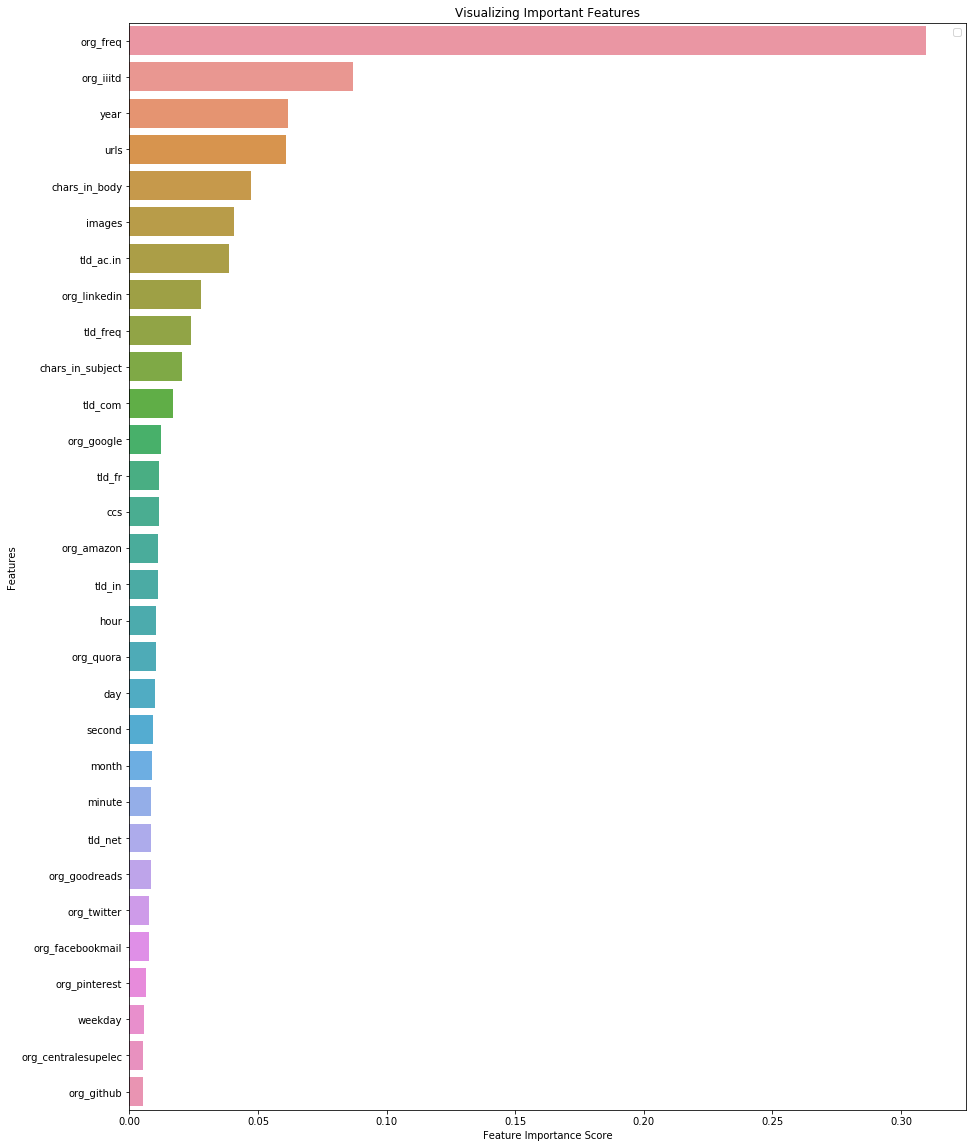

In [102]:
plt.figure(figsize=(15,20))
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [192]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, 120],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 200, 300],
    'class_weight' : ['balanced', {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

#Fit the grid search to the data
grid_search.fit(X_train_ao, y_train)
#grid_search.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.8min


ValueError: class_weight must be dict, 'balanced', or None, got: [{0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}]

In [154]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df_pred = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
df_pred.to_csv('test_submission_5.csv', index=False)

## Boosting

In [85]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(X_train_ao, y_train)
print(clf.score(X_train_ao, y_train))
#print(clf.best_params_)

ValueError: could not convert string to float: 'multipart/alternative'

In [ ]:
model = GradientBoostingClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

df_pred = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_test})
df_pred.to_csv('test_submission_5.csv', index=False)

## Neural Networks

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [126]:
def define_model_rnn(in_dim=150,units_1=450,units_2=50,units_3=200,learning_rate=0.0002):

    model = Sequential()
    model.add(Dense(units=units_1, activation='relu', input_dim=in_dim,kernel_regularizer=regularizers.l1(0.001),bias_regularizer=regularizers.l2(0.03)))
    model.add(Dense(units=units_2, activation='relu', input_dim=units_1,kernel_regularizer=regularizers.l1(0.001),bias_regularizer=regularizers.l2(0.03)))
    model.add(Dense(units=units_3, activation='relu', input_dim=units_2,kernel_regularizer=regularizers.l1(0.001),bias_regularizer=regularizers.l2(0.03)))
    model.add(Dense(units=4, activation='softmax',input_dim=units_3))
      
    opt = Adam(lr=learning_rate)
    
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

    return model

In [127]:
def fit_predict_rnn(model, X_train, X_test, Y_train):
    
    model.fit(X_train, Y_train, epochs=8, batch_size=40)
    classes = model.predict(X_test)
    
    y_pred = [np.argmax(classes[i]) for i in range (len(classes))]
    y_pred = np.array(y_pred)
    
    return model, y_pred

In [132]:
def feature_engineering_rnn(X_train, X_test):  

    pca = PCA(n_components = 150)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    return X_train, X_test

In [129]:
#think about class weight
def rnn(X_train,X_test,y_train,model_learning_rate=0.0002,weight_1=20.):

    #X_train = X_train.values
    #X_test = X_test.values
    y_train = y_train.values.ravel()
    
    model = define_model_rnn(learning_rate=model_learning_rate)
    
    #class_w = {0: 1.,
    #            1: weight_1}
    
    _,y_pred = fit_predict_rnn(model,X_train,X_test,y_train)
    
    return y_pred

In [130]:
X_train = train_df_0.drop(['label'], axis=1).copy()

X_train.values

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 15, ...,  0,  0,  0],
       [ 0,  0, 12, ...,  0,  0,  0],
       ...,
       [ 0,  0,  4, ...,  0,  0,  0],
       [ 4,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0]])

In [131]:
X_train = train_df_0.drop(['label'], axis=1).copy()
X_test = test_x_0.copy()
y_train = train_df.label

X_train, X_test = feature_engineering_rnn(X_train, X_test)

y_pred = rnn(X_train,X_test,y_train)

[[ 0  0  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  4 ...  0  0  0]
 [ 4  0  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]]
[[-1.22755229e+05 -3.21466737e+01 -5.21534635e+01 ...  1.01005711e-03
   1.87219358e-03  3.50940137e-03]
 [-8.73152289e+04  5.49972232e+00  1.29627127e+00 ... -6.48487169e-04
  -1.46102910e-03  7.35573290e-05]
 [-2.19892288e+04  7.06584242e+01  7.07574017e+00 ...  6.60076155e-04
   4.63470552e-04  1.72277388e-03]
 ...
 [-9.95772289e+04 -1.75229053e+01  2.41997001e+01 ...  8.78828450e-04
   4.16522269e-03 -1.33088942e-03]
 [-1.22005229e+05 -3.56328781e+01 -3.14202629e+01 ... -1.35497060e-03
  -1.44207874e-03 -9.09873242e-04]
 [-1.16300229e+05 -2.34830823e+01  1.08569154e+01 ... -1.24883792e-02
   1.61761067e-02 -1.83365825e-03]]
Train on 24840 samples
Epoch 1/8
24840/24840 [==============================] - 9s 370us/sample - loss: 158.0854 - accuracy: 0.3351
Epoch 2/8
24840/24840 [==============================] - 7s 277us/sample - l

In [122]:
res = pd.DataFrame({'ID': np.arange(len(y_test)),
                    'label': y_pred})
res.to_csv('test_submission_3.csv', index=False)

In [ ]:
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
train_x[['org']] = train_x[['org']].apply(lambda col: le.fit_transform(col))

In [ ]:
feat_enc_org = OneHotEncoder()
feat_enc_org.fit(train_x[['org']])
train_x_featurized = feat_enc_org.transform(train_x[['org']])

In [ ]:
## Do one hot encoding of categorical feature
feat_enc = OneHotEncoder()
feat_enc.fit(train_x)
train_x_featurized = feat_enc.transform(train_x)
test_x_featurized = feat_enc.transform(test_x)

## Train a simple KNN classifier using featurized data
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x_featurized, train_y)
pred_y = neigh.predict(test_x_featurized)

In [ ]:
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("knn_sample_submission.csv", index=True, index_label='Id')